参考情報：　kaggle1位の方　https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

このノートブックでは、現在Kaggle上で開催されているホームクレジットのデフォルトリスクの機械学習コンテストを最初に見てみましょう。このコンテストの目的は、過去のローン申込データを使用して、申込者がローンを返済できるかどうかを予測することです。これは、標準的な教師付き分類タスクです。

教師あり。訓練データにはラベルが含まれており、目標は特徴からラベルを予測するために学習するモデルを訓練することです。
分類します。ラベルは2進数で、0（ローンを時間通りに返済する）、1（ローンの返済が困難になる）です。

このデータは、銀行口座を持たない人々に信用枠（ローン）を提供することに特化したサービスであるHome Creditによって提供されています。顧客がローンを返済するかどうか、または困難を抱えているかどうかを予測することは、非常に重要なビジネス上のニーズであり、ホームクレジットは、機械学習コミュニティがどのような種類のモデルを開発してこのタスクを支援できるかを見るために、Kaggle上でこの競争を開催しています。

データのソースは7種類。

application_train/application_test: ホーム・クレジットの各ローン申請に関する情報を含む主なトレーニングとテストのデータ。各ローンはそれぞれ独自の行を持ち、SK_ID_CURR 機能によって識別されます。トレーニング・アプリケーション・データには、0: ローンが返済されたか、1: ローンが返済されなかったことを示す TARGET が付いています。

データを把握したら（列の説明を読むのは非常に役立ちます）、提出物がどのような基準で判断されるのかを理解する必要があります。この場合、それは「曲線下の受信機動作特性領域（ROC AUC、AUROCと呼ばれることもあります）」として知られている一般的な分類メトリックです。

ROC AUC は威圧的に聞こえるかもしれませんが、2 つの個別の概念を理解することができれば、比較的簡単に理解することができます。受信機動作特性（ROC）曲線は、真の陽性率と偽陽性率をグラフ化したものです。


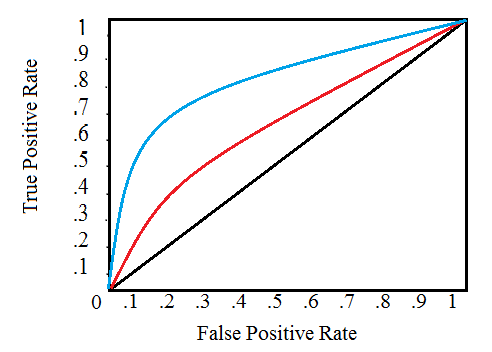


グラフ上の一本の線は一つのモデルの曲線を示し、線に沿った動きは、正のインスタンスを分類するための閾値を変化させることを示します。しきい値は、右上から左下で0から1になります。左側で別の曲線より上にある曲線は、より良いモデルを示しています。例えば、青のモデルは赤のモデルよりも優れており、ナイーブなランダム推測モデルを示す黒の対角線よりも優れていることを示しています。

曲線下面積(AUC)は、その名前で説明します! それは、単にROC曲線の下の面積です。(これは曲線の積分です。) このメトリックは0から1の間で、より良いモデルがより高いスコアを出します。単にランダムに推測するモデルは、ROC AUCが0.5になります。

我々がROC AUCに従って分類器を測定するとき、我々は0または1の予測を生成するのではなく、0と1の間の確率を生成します。 我々は通常、精度の観点から考えるのが好きなので、これは混乱するかもしれませんが、不均衡なクラスの問題に直面したとき（この場合がそうであることがわかります）、精度は最良の指標ではありません。例えば、99.9999%の精度でテロリストを検出できるモデルを作りたいと思ったら、私は単純に一人残らずテロリストではないと予測するモデルを作ります。明らかに、これは効果的ではありません（リコールはゼロになる）ので、分類器の性能をより正確に反映するために、ROC AUCやF1スコアのようなより高度なメトリクスを使用します。高いROC AUCを持つモデルも高い精度を持ちますが、ROC AUCはモデルの性能をより正確に表しています。

使用するデータの背景や最大化するメトリックがわかったわけではありませんが、早速データの探索に入りましょう。
このノートブックでは、先に述べたように、主要なデータソースと、今後の作業で構築できる単純なモデルに固執します。


In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns



from scipy.stats import kurtosis
from scipy.stats import skew
import pylab as pl
import missingno as msno
%matplotlib inline
pd.set_option('display.max_columns', 122)
pd.set_option('display.max_row', 1000)

### 【問題1】コンペティション内容の把握
コンペティションのOverviewページ読み、「Home Credit Default Risk」はどのようなコンペティションか、以下の観点からレポートしてください。


- Home Creditはどのような企業？
- このコンペティションでは何を予測する？
- それを予測することで企業が得られるメリットは何？

### ●Home Creditはどのような企業？

ホームクレジットは1997年にチェコ共和国で設立されたノンバンクの金融機関です。
積極的かつ安全な借入経験を提供することで、銀行口座を持たない人々のための金融包摂の拡大に努めている企業
同社は14カ国（米国、ロシア、カザスタン、ベラルーシ、中国、インドを含む）で事業を展開しており、主に融資を受けられなかったり、信用できない貸金業者の被害者となってしまった、信用履歴がほとんどない人たちへの融資に力を入れています。

Home Credit グループは、2900万人以上の顧客、210億ユーロの総資産、1億6,000万以上のローン、アジアでの大部分と中国でのほぼ半分の顧客を持っています（2018年5月19日現在）。

### ●このコンペティションでは何を予測する？

電話会社情報や取引情報を含む様々な代替データを利用し、顧客の返済能力を予測する。

### ●それを予測することで企業が得られるメリットは何？

返済確率が高い顧客と債務不履行の可能性が高い顧客への融資の可否の成否確率が向上する。

### データセットの準備
分析対象のデータセットはコンペティションのDataページからapplication_train.csvをダウンロードして使用します。


また同ページ内にあるHomeCredit_columns_description.csvは、データセットに関する説明となっています。


Dataページ内の他のcsvファイルはこの課題では扱いません。

In [2]:
df_train = pd.read_csv('application_train.csv')
df_train.shape

(307511, 122)

### 【問題2】データの概観の把握
データの概観を把握するために以下のようなことを行ってください。


- .head()、.info()、describe()などを使う
- 欠損値の有無を見る
- クラスの割合がわかるグラフを描く

それぞれ結果に対する説明や考察も行ってください。

### ●.head()、.info()、describe()などを使う

In [8]:
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [9]:
df_train[80:120]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
80       100095       0    Revolving loans           F            N   
81       100096       1         Cash loans           F            N   
82       100097       0         Cash loans           M            Y   
83       100098       0    Revolving loans           M            Y   
84       100099       0         Cash loans           F            N   
85       100100       0         Cash loans           M            Y   
86       100101       0         Cash loans           F            Y   
87       100102       0         Cash loans           F            N   
88       100103       0         Cash loans           F            N   
89       100104       0         Cash loans           F            N   
90       100105       0         Cash loans           F            N   
91       100108       0         Cash loans           F            N   
92       100110       0         Cash loans           M            Y   
93       100111       0         Cash loans           F            Y   
94       100112       1         Cash loans           M            Y   
95       100113       0         Cash loans           M            Y   
96       100114       0         Cash loans           F            N   
97       100115       0         Cash loans           F            N   
98       100116       0         Cash loans           F            N   
99       100118       0         Cash loans           F            N   
100      100119       0    Revolving loans           F            N   
101      100120       0         Cash loans           F            N   
102      100121       0         Cash loans           M            N   
103      100122       0         Cash loans           F            N   
104      100123       0         Cash loans           F            N   
105      100124       0         Cash loans           M            N   
106      100125       0         Cash loans           F            N   
107      100126       0    Revolving loans           M            N   
108      100127       0         Cash loans           M            N   
109      100129       0    Revolving loans           F            Y   
110      100130       1         Cash loans           F            N   
111      100131       0         Cash loans           F            N   
112      100132       0         Cash loans           F            N   
113      100133       0         Cash loans           F            N   
114      100134       0    Revolving loans           F            N   
115      100135       0         Cash loans           M            N   
116      100136       0         Cash loans           M            Y   
117      100137       0         Cash loans           F            Y   
118      100138       0         Cash loans           M            Y   
119      100139       0         Cash loans           F            N   

    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
80                Y             2           67500.0    135000.0       6750.0   
81                Y             0           81000.0    252000.0      14593.5   
82                Y             0          157500.0    760225.5      30280.5   
83                N             0          225000.0    270000.0      13500.0   
84                Y             0          360000.0    733315.5      41076.0   
85                Y             2          202500.0    796396.5      38443.5   
86                Y             0          202500.0    343377.0      22072.5   
87                N             1          126000.0    327024.0      10264.5   
88                Y             0           72000.0    450000.0      16965.0   
89                Y             0           90000.0    547344.0      30690.0   
90                Y             0          193500.0    225000.0      23755.5   
91                Y             3          171000.0    545040.0      31288.5   
92                Y             3          135000.0  

In [10]:
#登記された日がおそらく住民登録じゃないかと予測し、DAYS＿BIRTHと同値を検出し、TRUEだけを表示させたデータフレーム
bool_list = df_train.DAYS_BIRTH == df_train.DAYS_REGISTRATION
df_train[bool_list]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
311         100357       0    Revolving loans           F            N   
381         100439       1         Cash loans           M            N   
620         100709       0         Cash loans           M            Y   
800         100916       0         Cash loans           F            N   
873         101001       0         Cash loans           F            N   
1069        101241       0         Cash loans           M            Y   
1277        101506       0         Cash loans           M            N   
1713        102003       1         Cash loans           M            N   
2018        102365       0    Revolving loans           F            Y   
2281        102672       0         Cash loans           F            N   
2660        103106       0         Cash loans           F            N   
2680        103127       0         Cash loans           F            N   
2958        103450       0         Cash loans           F            N   
3579        104182       0         Cash loans           F            N   
3771        104404       0         Cash loans           M            N   
3946        104612       0         Cash loans           F            N   
4029        104711       0         Cash loans           F            N   
4160        104864       0         Cash loans           M            N   
4408        105153       0    Revolving loans           F            N   
4410        105155       1         Cash loans           F            N   
4587        105364       0         Cash loans           F            N   
5559        106508       1    Revolving loans           M            Y   
5695        106661       0         Cash loans           M            Y   
6009        107035       0         Cash loans           F            N   
6190        107228       0    Revolving loans           M            Y   
6526        107611       0         Cash loans           F            Y   
6568        107660       0         Cash loans           F            N   
6705        107824       0         Cash loans           M            N   
6740        107866       1         Cash loans           M            Y   
7256        108450       1         Cash loans           F            N   
7943        109261       0         Cash loans           F            N   
9032        110507       0         Cash loans           F            N   
9077        110554       0         Cash loans           M            Y   
9094        110572       0         Cash loans           M            N   
9245        110752       0         Cash loans           F            N   
9552        111103       0    Revolving loans           F            N   
10357       112058       0    Revolving loans           F            N   
10408       112119       0         Cash loans           M            Y   
10441       112158       1         Cash loans           M            Y   
10475       112197       0    Revolving loans           F            N   
10497       112226       0         Cash loans           F            Y   
11020       112833       0         Cash loans           M            N   
11435       113311       0         Cash loans           F            Y   
11830       113784       0         Cash loans           M            N   
11969       113955       0         Cash loans           M            Y   
11977       113964       0         Cash loans           F            N   
12191       114217       0         Cash loans           F            N   
12772       114891       1    Revolving loans           F            N   
12991       115142       0         Cash loans           M            Y   
13422       115648       0         Cash loans           F            N   
13628       115885       0         Cash loans           M            N   
14137       116484       0         Cash loans           M            N   
15193       117740       0         Cash loans           M            Y   
16192       

In [11]:
#データ同士で＝のものを見つけ、データの意味を予測する用
bool_list = df_train.REG_REGION_NOT_LIVE_REGION  == df_train.REG_CITY_NOT_LIVE_CITY
df_train[bool_list]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307505      456249       0         Cash loans           F            N   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307505               Y             0          112500.0    225000.0   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307505      22050.0         225000.0   Unaccompanied             Pensioner   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307505  Secondary / secondary special  Single / not married   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307505  House / apartment                    0.022800      -24384   
307506       With parents       

In [13]:
df_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

### ●欠損値の有無を見る

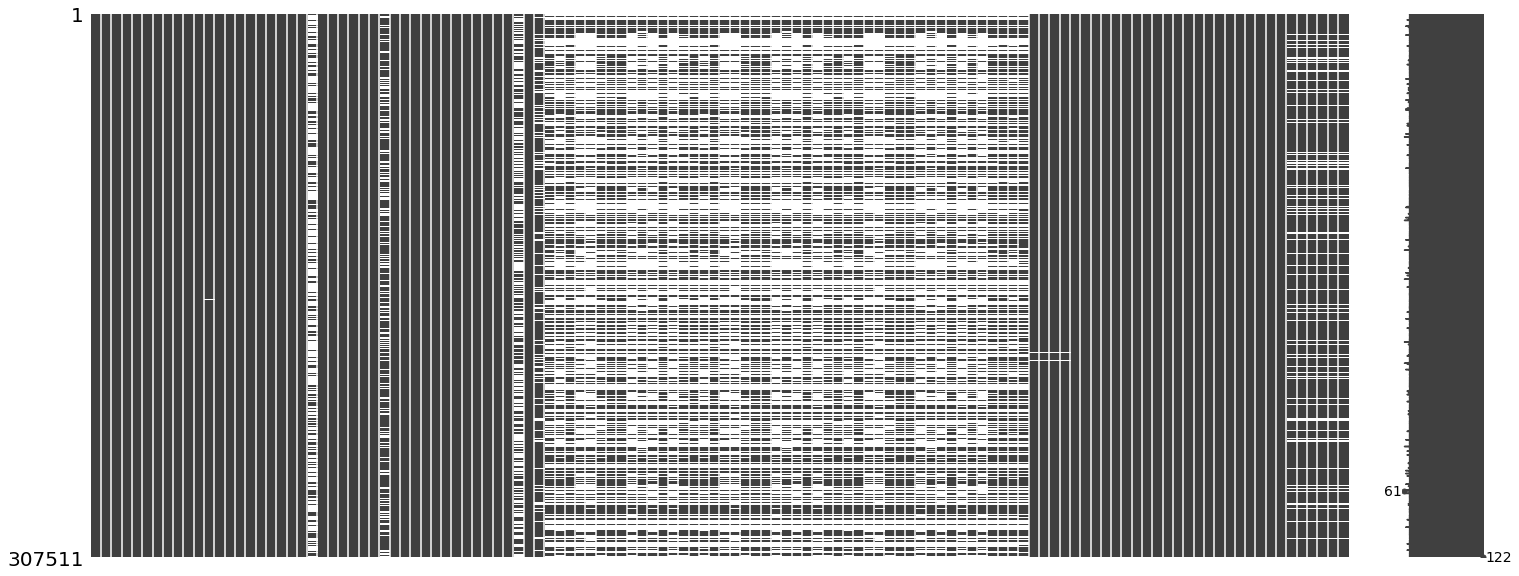

In [14]:
#columns毎の欠損値の数に一覧性を求めたもの
'''
途中にある欠損値が連続するcolumnsは削除してもいいかもしれない
'''
msno.matrix(df_train);

In [15]:
#columns毎の欠損値の数
df_train.isna().sum().sort_values(ascending = False)

COMMONAREA_MEDI                 214865
COMMONAREA_AVG                  214865
COMMONAREA_MODE                 214865
NONLIVINGAPARTMENTS_MODE        213514
NONLIVINGAPARTMENTS_MEDI        213514
NONLIVINGAPARTMENTS_AVG         213514
FONDKAPREMONT_MODE              210295
LIVINGAPARTMENTS_MEDI           210199
LIVINGAPARTMENTS_MODE           210199
LIVINGAPARTMENTS_AVG            210199
FLOORSMIN_MEDI                  208642
FLOORSMIN_MODE                  208642
FLOORSMIN_AVG                   208642
YEARS_BUILD_MEDI                204488
YEARS_BUILD_AVG                 204488
YEARS_BUILD_MODE                204488
OWN_CAR_AGE                     202929
LANDAREA_MODE                   182590
LANDAREA_AVG                    182590
LANDAREA_MEDI                   182590
BASEMENTAREA_MEDI               179943
BASEMENTAREA_AVG                179943
BASEMENTAREA_MODE               179943
EXT_SOURCE_1                    173378
NONLIVINGAREA_MEDI              169682
NONLIVINGAREA_AVG        

In [49]:
#欠損値があるcolumnsの欠損率が分かる

'''
欠損率47%までのcolumnには前処理してもいいか考えたかったが
そのcolumnの重要性が分からないため保留
'''
null_count = df_train.isnull().sum() #columns毎の欠損値の数を変数に代入する
null_rate = null_count / len(df_train) #それを全顧客数と割る

null_table = pd.DataFrame({'null_count': null_count,'null_rate': null_rate})

null_table.sort_values(by='null_rate', ascending=False)

null_count  null_rate
COMMONAREA_MEDI                   214865   0.698723
COMMONAREA_AVG                    214865   0.698723
COMMONAREA_MODE                   214865   0.698723
NONLIVINGAPARTMENTS_MODE          213514   0.694330
NONLIVINGAPARTMENTS_AVG           213514   0.694330
NONLIVINGAPARTMENTS_MEDI          213514   0.694330
FONDKAPREMONT_MODE                210295   0.683862
LIVINGAPARTMENTS_MODE             210199   0.683550
LIVINGAPARTMENTS_AVG              210199   0.683550
LIVINGAPARTMENTS_MEDI             210199   0.683550
FLOORSMIN_AVG                     208642   0.678486
FLOORSMIN_MODE                    208642   0.678486
FLOORSMIN_MEDI                    208642   0.678486
YEARS_BUILD_MEDI                  204488   0.664978
YEARS_BUILD_MODE                  204488   0.664978
YEARS_BUILD_AVG                   204488   0.664978
OWN_CAR_AGE                       202929   0.659908
LANDAREA_MEDI                     182590   0.593767
LANDAREA_MODE                     182590   0.593767
LANDAREA_AVG                      182590   0.593767
BASEMENTAREA_MEDI                 179943   0.585160
BASEMENTAREA_AVG                  179943   0.585160
BASEMENTAREA_MODE                 179943   0.585160
EXT_SOURCE_1                      173378   0.563811
NONLIVINGAREA_MODE                169682   0.551792
NONLIVINGAREA_AVG                 169682   0.551792
NONLIVINGAREA_MEDI                169682   0.551792
ELEVATORS_MEDI                    163891   0.532960
ELEVATORS_AVG                     163891   0.532960
ELEVATORS_MODE                    163891   0.532960
WALLSMATERIAL_MODE                156341   0.508408
APARTMENTS_MEDI                   156061   0.507497
APARTMENTS_AVG                    156061   0.507497
APARTMENTS_MODE                   156061   0.507497
ENTRANCES_MEDI                    154828   0.503488
ENTRANCES_AVG                     154828   0.503488
ENTRANCES_MODE                    154828   0.503488
LIVINGAREA_AVG                    154350   0.501933
LIVINGAREA_MODE                   154350   0.501933
LIVINGAREA_MEDI                   154350   0.501933
HOUSETYPE_MODE                    154297   0.501761
FLOORSMAX_MODE                    153020   0.497608
FLOORSMAX_MEDI                    153020   0.497608
FLOORSMAX_AVG                     153020   0.497608
YEARS_BEGINEXPLUATATION_MODE      150007   0.487810
YEARS_BEGINEXPLUATATION_MEDI      150007   0.487810
YEARS_BEGINEXPLUATATION_AVG       150007   0.487810
TOTALAREA_MODE                    148431   0.482685
EMERGENCYSTATE_MODE               145755   0.473983
OCCUPATION_TYPE                    96391   0.313455
EXT_SOURCE_3                       60965   0.198253
AMT_REQ_CREDIT_BUREAU_HOUR         41519   0.135016
AMT_REQ_CREDIT_BUREAU_DAY          41519   0.135016
AMT_REQ_CREDIT_BUREAU_WEEK         41519   0.135016
AMT_REQ_CREDIT_BUREAU_MON          41519   0.135016
AMT_REQ_CREDIT_BUREAU_QRT          41519   0.135016
AMT_REQ_CREDIT_BUREAU_YEAR         41519   0.135016
NAME_TYPE_SUITE                     1292   0.004201
OBS_30_CNT_SOCIAL_CIRCLE            1021   0.003320
DEF_30_CNT_SOCIAL_CIRCLE            1021   0.003320
OBS_60_CNT_SOCIAL_CIRCLE            1021   0.003320
DEF_60_CNT_SOCIAL_CIRCLE            1021   0.003320
EXT_SOURCE_2                         660   0.002146
AMT_GOODS_PRICE                      278   0.000904
AMT_ANNUITY                           12   0.000039
CNT_FAM_MEMBERS                        2   0.000007
DAYS_LAST_PHONE_CHANGE                 1   0.000003
CNT_CHILDREN                           0   0.000000
FLAG_DOCUMENT_8                        0   0.000000
NAME_CONTRACT_TYPE                     0   0.000000
CODE_GENDER                            0   0.000000
FLAG_OWN_CAR                           0   0.000000
FLAG_DOCUMENT_2                        0   0.000000
FLAG_DOCUMENT_3                        0   0.000000
FLAG_DOCUMENT_4                        0   0.000000
FLAG_DOCUMENT_5                        0   0.000000
FLAG_DOCUMENT_6           

### ●クラスの割合がわかるグラフを描く

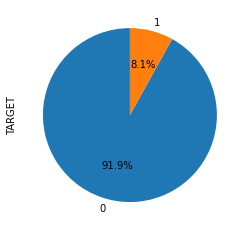

In [42]:
#債務不履行者の方が少ない
df_train['TARGET'].value_counts().plot(kind='pie', startangle=90, autopct="%1.1f%%");

In [44]:
# def correlation_ratio(categories, measurements):
#         fcat, _ = pd.factorize(categories)
#         cat_num = np.max(fcat)+1
#         y_avg_array = np.zeros(cat_num)
#         n_array = np.zeros(cat_num)
#         for i in range(0,cat_num):
#             cat_measures = measurements[np.argwhere(fcat == i).flatten()]
#             n_array[i] = len(cat_measures)
#             y_avg_array[i] = np.average(cat_measures)
#         y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
#         numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
#         denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
#         if numerator == 0:
#             eta = 0.0
#         else:
#             eta = numerator/denominator
#         return eta

In [40]:
#目的変数のヒストグラム
# sns.distplot(df_train.TARGET);
# #sns.histplot(df_train_log);
# print(kurtosis(df_train.TARGET))
# print(skew(df_train.TARGET))

In [50]:
# 目的変数の2ラベルのカウント数
# temp = df_train["TARGET"].value_counts()
# df = pd.DataFrame({'labels': temp.index,
#                    'values': temp.values
#                   })
# plt.figure(figsize = (6,6))
# plt.title('Application loans repayed - train dataset')
# sns.set_color_codes("pastel")
# sns.barplot(x = 'labels', y="values", data=df)
# locs, labels = plt.xticks()
# plt.show()

In [41]:
# 左は0の支払い方法と人数、右は1

# def plot_stats(feature,label_rotation=False,horizontal_layout=True):
#     temp = df_train[feature].value_counts()
#     df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

#     # Calculate the percentage of target=1 per category value
#     cat_perc = df_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
#     cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
#     if(horizontal_layout):
#         fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
#     else:
#         fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
#     sns.set_color_codes("pastel")
#     s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
#     if(label_rotation):
#         s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
#     s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
#     if(label_rotation):
#         s.set_xticklabels(s.get_xticklabels(),rotation=90)
#     plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
#     plt.tick_params(axis='both', which='major', labelsize=10)

#     plt.show();
# def plot_distribution(var):
    
#     i = 0
#     t1 = df_train.loc[df_train['TARGET'] != 0]
#     t0 = df_train.loc[df_train['TARGET'] == 0]

#     sns.set_style('whitegrid')
#     plt.figure()
#     fig, ax = plt.subplots(2,2,figsize=(12,12))

#     for feature in var:
#         i += 1
#         plt.subplot(2,2,i)
#         sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
#         sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
#         plt.ylabel('Density plot', fontsize=12)
#         plt.xlabel(feature, fontsize=12)
#         locs, labels = plt.xticks()
#         plt.tick_params(axis='both', which='major', labelsize=12)
#     plt.show();
# plot_stats('NAME_CONTRACT_TYPE') 

### 【問題3】課題設定
データの概観を見たことを元に、自分なりの課題・疑問を複数設定してください。

#### 目的変数と相関係数が高い説明変数を探す
→目的変数に対して高いものは見つからないので別のアプローチから試す

#### 目的変数のデータ分布確認
→不均衡データであることがわかる

#### AMT_CREDITを確認する(TARGETに影響を与えやすそう)
→尖度、歪度とも偏っているので対数変換して正規分布に寄らせる

#### AMT_CREDITを対数変換して正規分布に寄らせる
→不恰好だがこれで進めてみる(おそらく異常値が存在しているからか？)

#### AMT_CREDITの外れ値を探してみる
→プロットの方法が間違ってるか分からないが、maxの値も含め外れ値が多い。外れ値とも言いづらいのかもしれないので一旦気にせずに、AMT＿CREDITで相関関係を確認してみる

#### AMT_CREDITと相関係数が高い説明変数同士で相関係数が高いものを探す
→AMT_ANNUITYとAMT_GOODS_PRICEの相関係数が高い。他にもあるが、0.95を超える値であった。高すぎるのも調査に値しない可能性が高いので一旦置いておく。

#### AMT_CREDITとAMT_ANNUITYとAMT_GOODS_PRICE同士の分布を見る
→外れ値のようなものはあるが、それぞれが正の相関関係にある

#### 上記3つの説明変数の増減とTARGETのviolinplotで可視化してみる
→AMT_ANNUITYのdefaultの20000から 40000の値がその他の説明変数に対してズレがあるため、この値に対応している行を抜き出してみる

#### AMT_ANNUITYの17500から40000の値を持っている行を抜き出す
→

#### 抜き出したデータで相関係数が高そうなものを探す
→＊＊＊ここで終了＊＊＊



<!-- #### DAYS_EMPLOYEDのとんでもない値に対して対応したいし、この値でTARGETの割合を確認したい↓

#### NAME_TYPE_SUITEの値によってTARGET変数に影響が出ていないか

#### ここまでcolumnsの意味と数字を少し見たが、間違っているデータがいくつか存在する。そのデータを見極めて、削除したい

#### どの特徴量に対しても外れ値であるcolumnsを外すには

#### 欠損率が高いデータを削除しても、データ分析に影響が出ないかどうか

#### AMT_REQ_CREDIT_BUREAU_  この値の大きさで貸し借りの多さがわかるから怪しそう

#### REG_CITY_NOT_LIVE_CITYとREG_CITY_NOT_WORK_CITYの違い

#### REGION_POPULATION_RELATIVEに対してのTARGETの割合　0と1で住んでいる地域に一貫性があるかどうか

#### DAYS_BIRTHとDAYS_REGISTRATIONが同じでNAME_HOUSING_TYPEがwithparentsの債務不履行の割合→何と比較したら高いとか低いとか出るのだろう

#### 携帯電話をとったかどうかは影響大きそうだがどうだろう　FLAG_CONT_MOBILE

#### 本籍地と住んでる場所が地域レベルでも都市レベルでも同じ人が多かったがこれはTARGETとの相関はあるのか

#### EXIT_SOURCEが影響与えてそうかどうかを判断したい -->

### 【問題4】データ探索
問題3で設定した課題・疑問を解決するためにデータ探索を進めます。探索で使用する表やグラフを、考察と共に 15個以上 作成してください。

探索過程で新しい疑問点が生まれた場合は、問題3の回答に加えていってください。

### 目的変数と相関係数が高い説明変数を探す

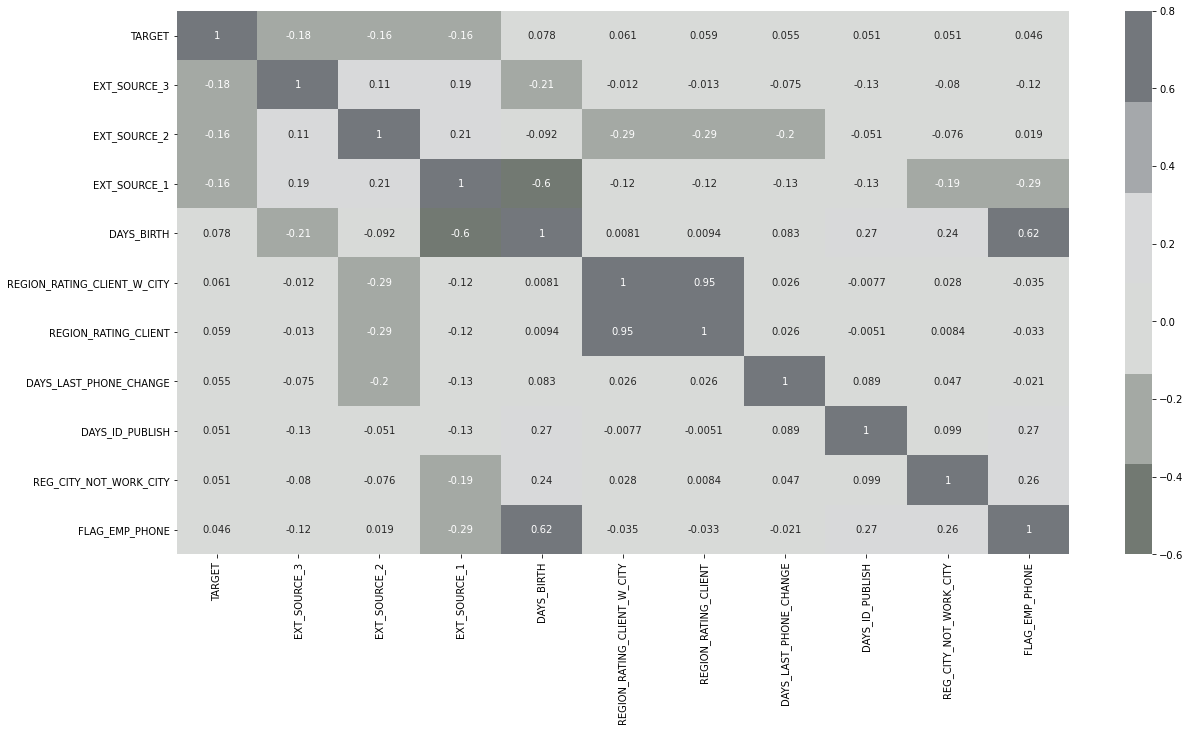

In [81]:
#相関係数行列後にTARGETとの相関係数が高い(絶対値)10個までの列をtop_featuresに代入する

df_train_corr= df_train.corr()
df_train_corr_abs = df_train_corr["TARGET"].abs().nlargest(11) 

top_features = df_train_corr_abs.index #特徴名だけが出てくる .index

plt.figure(figsize=(20,10))

pal = sns.diverging_palette(128, 240, 8) #絶対値で出しているから、カラーじゃなくて濃淡だけでやってるのか

sns.heatmap(df_train[top_features].corr(), vmax=0.8, annot=True, cmap=pal) #ここでtop_featuresだけで相関係数行列している
plt.show()

### 目的変数のデータ分布確認

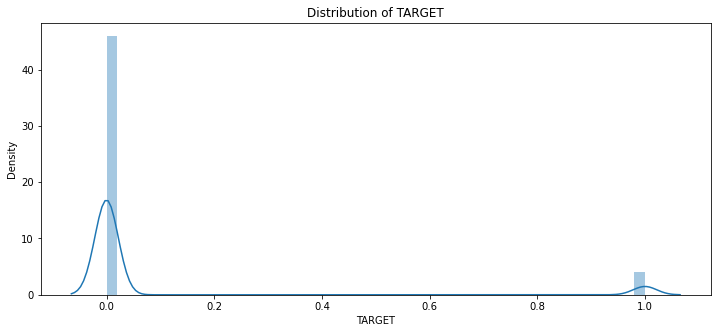

In [67]:
#分布を調べるにはヒストグラム、変数1つに対して対応するからbarとlineのヒストグラムになる

#不均衡な分布である
plt.figure(figsize=(12,5))
plt.title("Distribution of TARGET")
ax = sns.distplot(df_train["TARGET"].dropna())

### AMT_CREDITの分布を確認

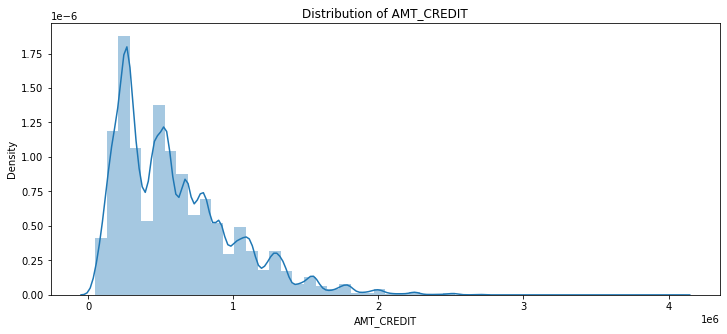

In [68]:
plt.figure(figsize=(12, 5))
plt.title('Distribution of AMT_CREDIT')
sns.distplot(df_train["AMT_CREDIT"]);

### AMT_CREDITを対数変換して正規分布に寄らせる

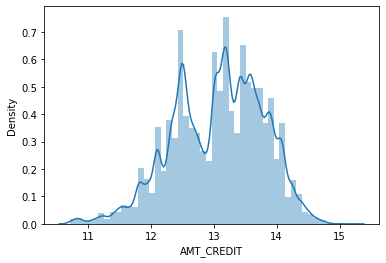

In [70]:
AMT_CREDIT_log = df_train.AMT_CREDIT.apply(np.log)
sns.distplot(AMT_CREDIT_log);

### AMT_CREDITの異常値を探してみる

<AxesSubplot:xlabel='AMT_CREDIT'>

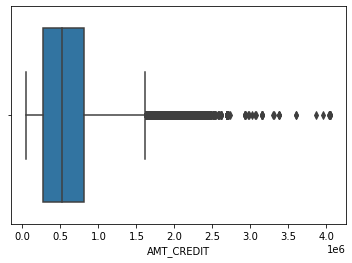

In [79]:
sns.boxplot(df_train['AMT_CREDIT'])

In [83]:
df_train[['AMT_CREDIT']].describe()

AMT_CREDIT
count  3.075110e+05
mean   5.990260e+05
std    4.024908e+05
min    4.500000e+04
25%    2.700000e+05
50%    5.135310e+05
75%    8.086500e+05
max    4.050000e+06

### AMT_CREDITとの相関係数が高そうな説明変数を探す

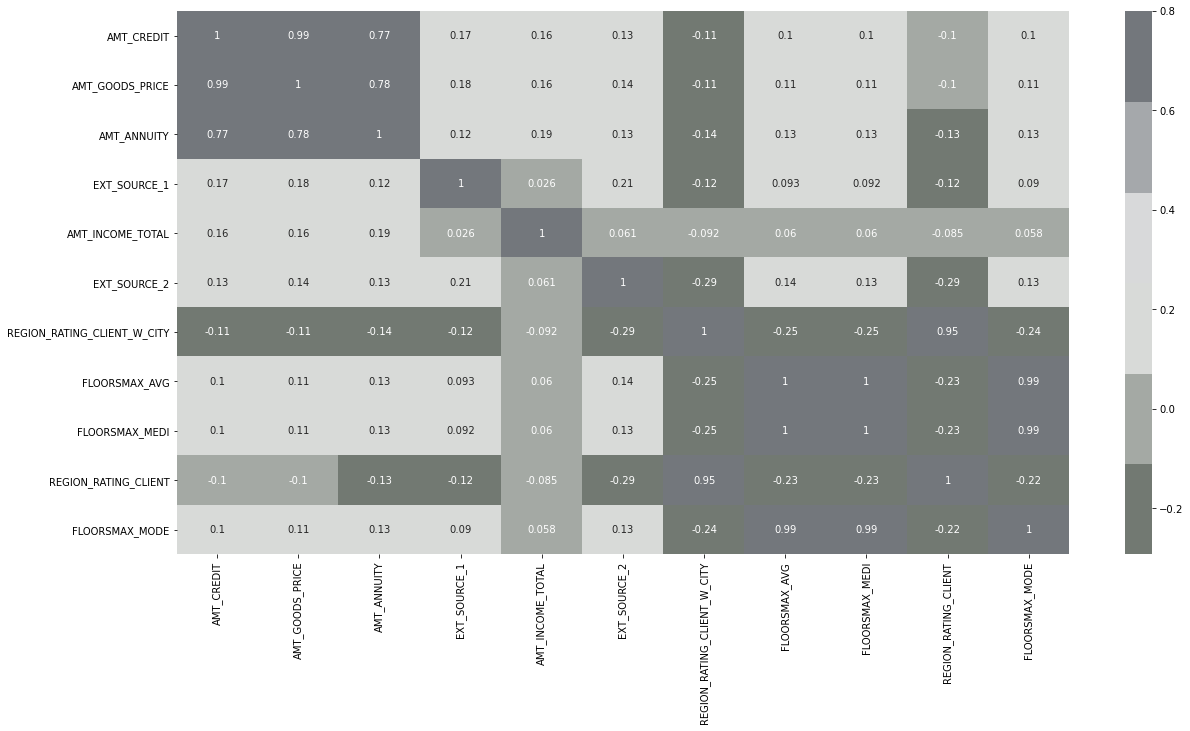

In [80]:
#AMT_CREDIT_log.corr
df_train_corr= df_train.corr()
df_train_corr_abs = df_train_corr["AMT_CREDIT"].abs().nlargest(11) 

top_features = df_train_corr_abs.index #特徴名だけが出てくる .index

plt.figure(figsize=(20,10))

pal = sns.diverging_palette(128, 240, 8) #絶対値で出しているから、カラーじゃなくて濃淡だけでやってるのか

sns.heatmap(df_train[top_features].corr(), vmax=0.8, annot=True, cmap=pal) #ここでtop_featuresだけで相関係数行列している
plt.show()

### AMT_CREDITとAMT_ANNUITYとAMT_GOODS_PRICE同士の分布を見る

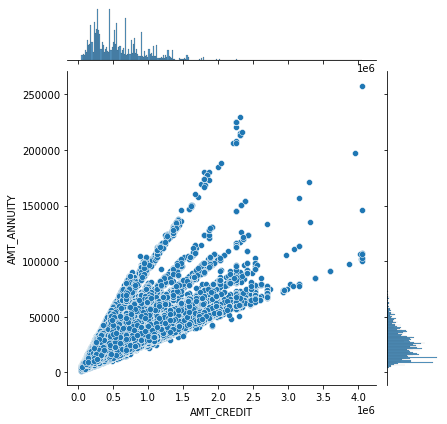

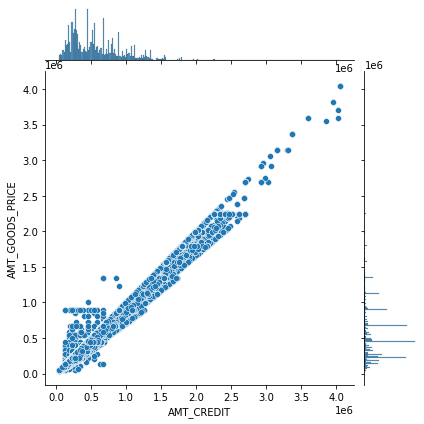

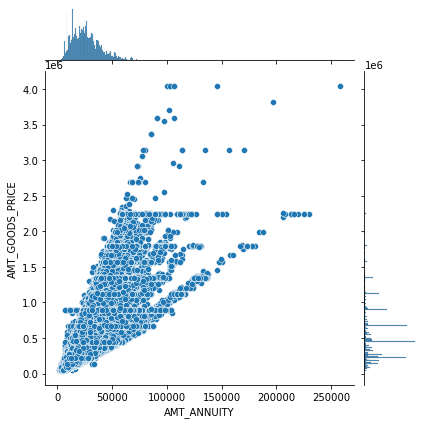

In [94]:
sns.jointplot('AMT_CREDIT', 'AMT_ANNUITY', data =df_train)
plt.show()

sns.jointplot('AMT_CREDIT', 'AMT_GOODS_PRICE', data =df_train)
plt.show()

sns.jointplot('AMT_ANNUITY', 'AMT_GOODS_PRICE', data=df_train)

### 上記3つの説明変数の増減とTARGETのviolinplotで可視化してみる

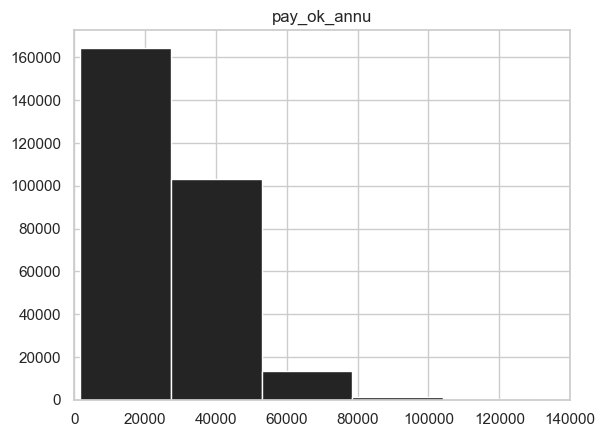

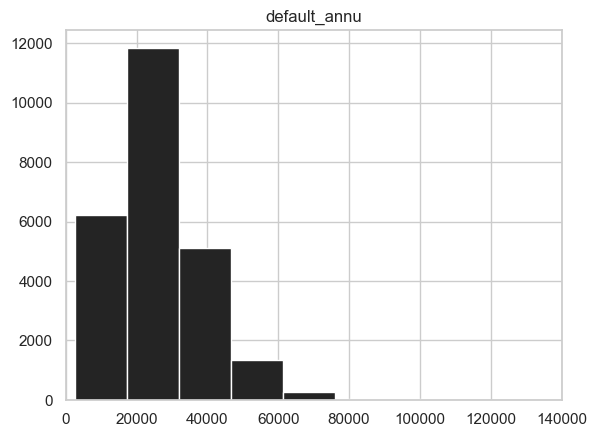

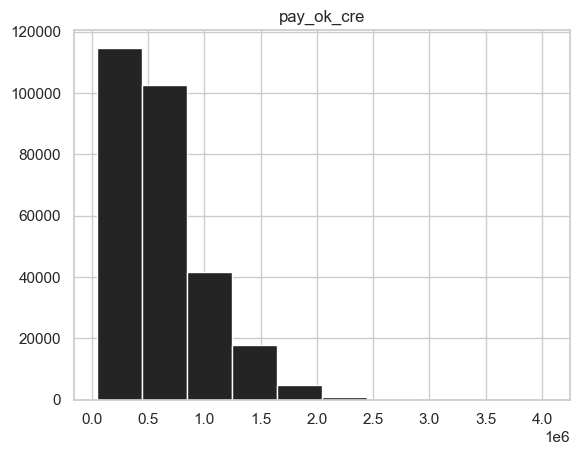

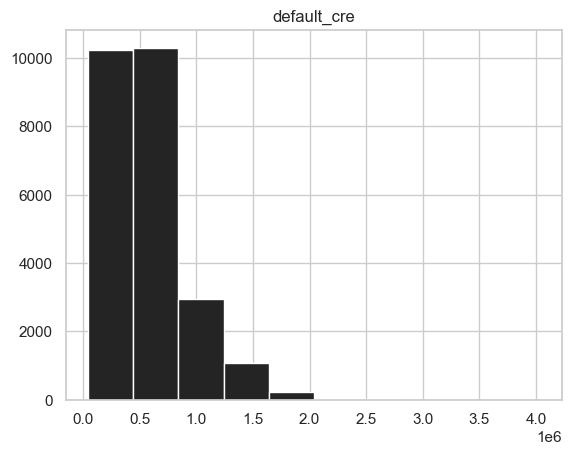

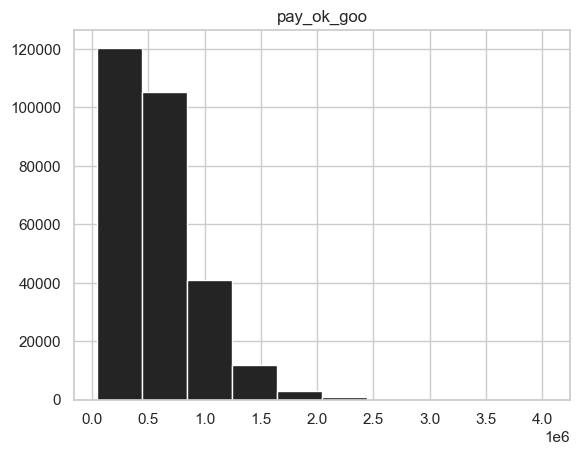

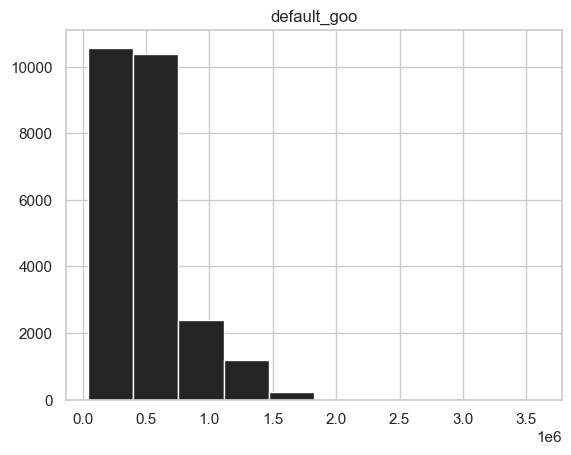

In [120]:
#https://pythondatascience.plavox.info/pandas/%E8%A1%8C%E3%83%BB%E5%88%97%E3%81%AE%E6%8A%BD%E5%87%BA


pay_ok_annu = df_train.AMT_ANNUITY[df_train.TARGET == 0]
default_annu = df_train.AMT_ANNUITY[df_train.TARGET == 1]

plt.title('pay_ok_annu')
plt.hist(pay_ok_annu)
plt.xlim(0,140000)
plt.show()

plt.title('default_annu')
plt.hist(default_annu)
plt.xlim(0,140000)
plt.show()


pay_ok_cre = df_train.AMT_CREDIT[df_train.TARGET == 0]
default_cre = df_train.AMT_CREDIT[df_train.TARGET == 1]

plt.title('pay_ok_cre')
plt.hist(pay_ok_cre)
#plt.xlim(0,140000)
plt.show()

plt.title('default_cre')
plt.hist(default_cre)
#plt.xlim(0,140000)
plt.show()


pay_ok_goo = df_train.AMT_GOODS_PRICE[df_train.TARGET == 0]
default_goo = df_train.AMT_GOODS_PRICE[df_train.TARGET == 1]

plt.title('pay_ok_goo')
plt.hist(pay_ok_goo)
#plt.xlim(0,140000)
plt.show()

plt.title('default_goo')
plt.hist(default_goo)
#plt.xlim(0,140000)
plt.show()

### AMT_ANNUITYの17500から40000の値を持っている行を抜き出す

In [139]:
amt_ann =df_train[df_train.TARGET == 1][df_train.AMT_ANNUITY
                                                                      >17500][df_train.AMT_ANNUITY<40000]
print(amt_ann)

        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
26          100031       1         Cash loans           F            N   
40          100047       1         Cash loans           M            N   
110         100130       1         Cash loans           F            N   
138         100160       1         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307386      456112       1         Cash loans           F            N   
307448      456186       1         Cash loans           M            N   
307481      456225       1         Cash loans           M            N   
307489      456233       1         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0     

### 抜き出したデータで相関係数が高そうなものを探す

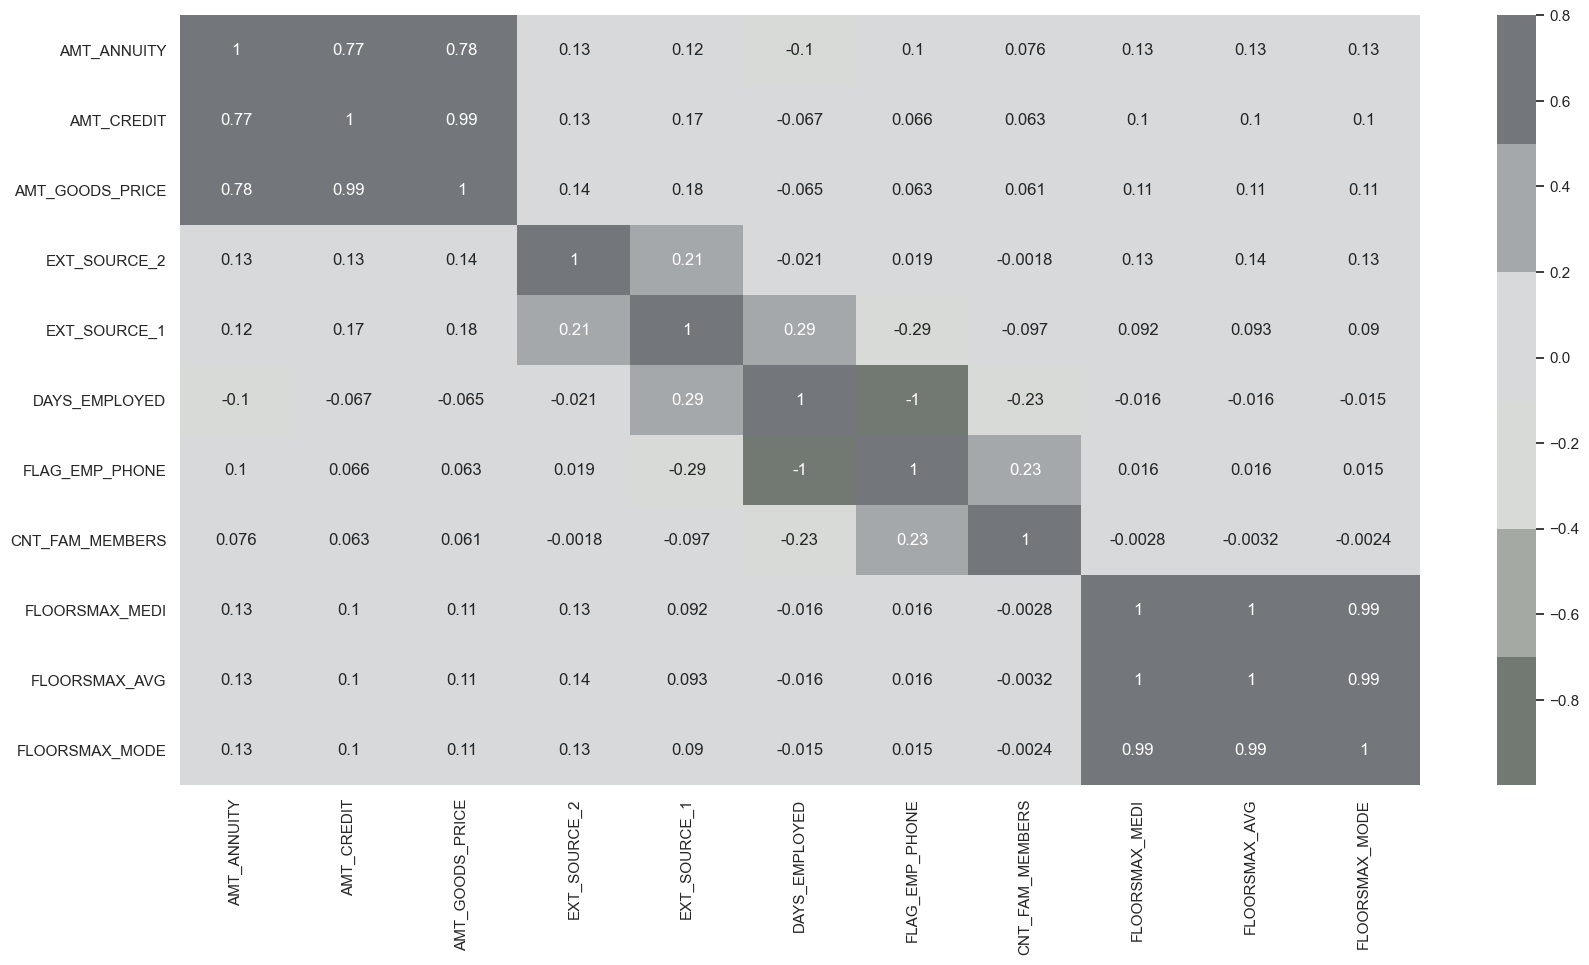

In [150]:
amt_ann_pd = pd.DataFrame(amt_ann)

df_train_corr= amt_ann_pd.corr()
df_train_corr_abs = df_train_corr["AMT_ANNUITY"].abs().nlargest(11) 

top_features = df_train_corr_abs.index #特徴名だけが出てくる .index

plt.figure(figsize=(20,10))

pal = sns.diverging_palette(128, 240, 8) #絶対値で出しているから、カラーじゃなくて濃淡だけでやってるのか

sns.heatmap(df_train[top_features].corr(), vmax=0.8, annot=True, cmap=pal) #ここでtop_featuresだけで相関係数行列している
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot('FLAG_EMP_PHONE',data=df_train,hue='TARGET')
plt.show()

### 【問題5】（アドバンス課題）Notebooksへの投稿
必須ではありませんが、コンペティションのNotebooksページに今回作成したEDAのノートブックを投稿することを推奨しています。

### 重要参考データ

https://www.boj.or.jp/announcements/release_2019/data/rel190215d2.pdf
→りそな銀行　AIを活用した信用評価手法の　現状とこれから